### This (auxiliary) notebook shows CelebA/LSUN classifier evaluation according to conventional performance metrics

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from latentspace.datasets import *
from latentspace.ml_util import *
from latentspace.cnn import *
from latentspace.adversarial_generation import *
from latentspace.evaluation_util import EvaluationUtil

### Load dataset

* Comment/uncomment to switch between CelebA and LSUN

In [3]:
dataset_info = DatasetInfo.CelebA128Gender
#dataset_info = DatasetInfo.LSUN128

if dataset_info == DatasetInfo.CelebA128Gender:
    trainer_name = "celeba-128"
    ds = CelebAData(20)
    no_classes = 2
elif dataset_info == DatasetInfo.LSUN128:
    trainer_name = "lsun-128"
    ds = LSUNData()
    no_classes = 2
else:
    raise RuntimeError()
class_weights = [1 / no_classes] * no_classes

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


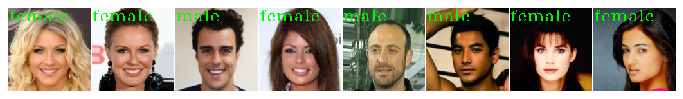

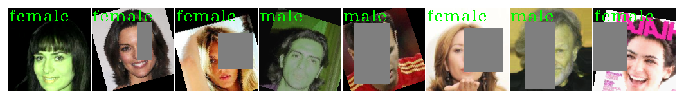

In [4]:
# get some random training images (without data augmentation, with conventional data augmentation)
for loader in [ds.get_unaugmented_train_loader(batch_size=8), ds.get_train_loader(batch_size=8)]:
    images, labels = next(iter(loader))
    Util.imshow_tensors(images, captions=ds.prediction_indices_to_printed_classes(labels), nrow=8)

### Load classifiers

In [5]:
filenames = "oneepoch plain conventional robust both".split(" ")
#unit_types = [0, 1, 2]
unit_types = [1]
def load_classifier(filename: str, unit_type: int):   
    weights_filename = f"classifiers_architecture{unit_type}/{filename}_{dataset_info.name}.bin"
    c = Trainer(trainer_name, ds.get_train_loader, ds.get_test_loader, unit_type)
    c.restore_params_from_disk(weights_filename)
    return c
classifiers = [load_classifier(filename, unit_type) for unit_type in unit_types for filename in filenames]

celeba-128 classifier: 201798 trainable parameters
celeba-128 classifier: 201798 trainable parameters
celeba-128 classifier: 201798 trainable parameters
celeba-128 classifier: 201798 trainable parameters
celeba-128 classifier: 201798 trainable parameters


### A few predictions

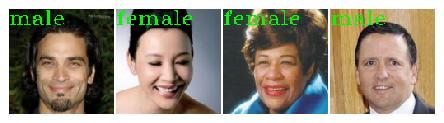

Predicted 0: ['male', 'female', 'female', 'male']
Predicted 1: ['male', 'female', 'male', 'male']
Predicted 2: ['male', 'female', 'female', 'male']
Predicted 3: ['male', 'female', 'male', 'male']
Predicted 4: ['male', 'female', 'male', 'male']


In [6]:
EvaluationUtil.show_some_predictions(classifiers, ds)

### Classifier evaluation: clean accuracy and noise corruption accuracy (on the validation set)

In [7]:
EvaluationUtil.evaluate_accuracy(classifiers, ds, 100)

Accuracy of classifier 0 on 100 validation images (noise 0.0):  99.00%
Accuracy of classifier 0 on 100 validation images (noise 0.8):  52.00%
Accuracy of classifier 1 on 100 validation images (noise 0.0):  98.00%
Accuracy of classifier 1 on 100 validation images (noise 0.8):  48.00%
Accuracy of classifier 2 on 100 validation images (noise 0.0):  94.00%
Accuracy of classifier 2 on 100 validation images (noise 0.8):  52.00%
Accuracy of classifier 3 on 100 validation images (noise 0.0):  96.00%
Accuracy of classifier 3 on 100 validation images (noise 0.8):  93.00%
Accuracy of classifier 4 on 100 validation images (noise 0.0):  96.00%
Accuracy of classifier 4 on 100 validation images (noise 0.8):  93.00%


### Evaluation: adversarial frequency and severity in the original space (on the validation set)

* Adversarial frequency = accuracy on worst-case perturbed images within allowed bounds
* Adversarial severity = expected size of a minimum adversarial perturbation

In [8]:
EvaluationUtil.evaluate_conventional_robustness(classifiers, ds, 4, l_2_bounds=[0.0025, 0.005], l_inf_bounds=[0.005, 0.01])

For classifier 0, (scaled_l_2) ||dx|| <= 0.002500, accuracy on 4 images =   0.00%
For classifier 1, (scaled_l_2) ||dx|| <= 0.002500, accuracy on 4 images =  25.00%
For classifier 2, (scaled_l_2) ||dx|| <= 0.002500, accuracy on 4 images =   0.00%
For classifier 3, (scaled_l_2) ||dx|| <= 0.002500, accuracy on 4 images = 100.00%
For classifier 4, (scaled_l_2) ||dx|| <= 0.002500, accuracy on 4 images =  75.00%
For classifier 0, (scaled_l_2) ||dx|| <= 0.005000, accuracy on 4 images =   0.00%
For classifier 1, (scaled_l_2) ||dx|| <= 0.005000, accuracy on 4 images =   0.00%
For classifier 2, (scaled_l_2) ||dx|| <= 0.005000, accuracy on 4 images =   0.00%
For classifier 3, (scaled_l_2) ||dx|| <= 0.005000, accuracy on 4 images =  75.00%
For classifier 4, (scaled_l_2) ||dx|| <= 0.005000, accuracy on 4 images =  50.00%
For classifier 0, (     l_inf) ||dx|| <= 0.005000, accuracy on 4 images =  50.00%
For classifier 1, (     l_inf) ||dx|| <= 0.005000, accuracy on 4 images =  25.00%
For classifier 2

In [9]:
EvaluationUtil.evaluate_conventional_adversarial_severity(classifiers, ds, 4, OTHER_L2_UPPER_BOUND, OTHER_LINF_UPPER_BOUND)

Adversarial severity of classifier 0 with scaled_l_2 norm = 0.00159417 (std = 0.00120526, #images = 4)
Adversarial severity of classifier 1 with scaled_l_2 norm = 0.00171263 (std = 0.00137681, #images = 4)
Adversarial severity of classifier 2 with scaled_l_2 norm = 0.00346271 (std = 0.00277211, #images = 4)
Adversarial severity of classifier 3 with scaled_l_2 norm = 0.01627821 (std = 0.00446733, #images = 4)
Adversarial severity of classifier 4 with scaled_l_2 norm = 0.01283486 (std = 0.00234789, #images = 4)
Adversarial severity of classifier 0 with      l_inf norm = 0.00361399 (std = 0.00468086, #images = 4)
Adversarial severity of classifier 1 with      l_inf norm = 0.00719026 (std = 0.00435723, #images = 4)
Adversarial severity of classifier 2 with      l_inf norm = 0.00667430 (std = 0.00857306, #images = 4)
Adversarial severity of classifier 3 with      l_inf norm = 0.03215219 (std = 0.01339756, #images = 4)
Adversarial severity of classifier 4 with      l_inf norm = 0.02043936 (s

### Evaluation: optimize class activations

* Robust classifiers should be capable of limited image generation by maximizing their class activations
* Here, this is visible only on CelebA

classifier 0:


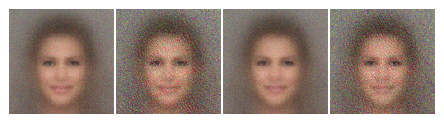

classifier 1:


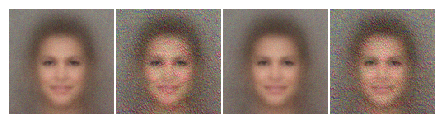

classifier 2:


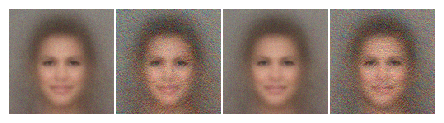

classifier 3:


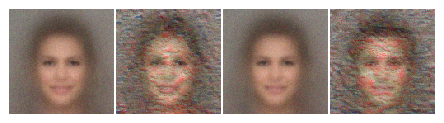

classifier 4:


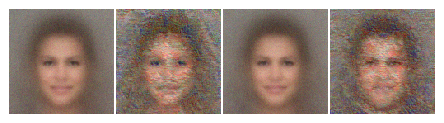

In [11]:
generate = lambda *args: EvaluationUtil.generate_images_with_classifier(classifiers, ds, no_classes, *args)
if dataset_info == DatasetInfo.CelebA128Gender:
    generate(0.05, "l_inf", 0.3)
else:
    generate(0.1, "scaled_l_2", 0.6)